In [1]:
"""
!pip install Augmentor
!pip install pillow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install keras
!unzip ./python/images_background.zip
!unzip ./python/images_background_small1.zip
!unzip ./python/images_background_small2.zip
!unzip ./python/images_evaluation.zip
"""

'\n!pip install Augmentor\n!pip install pillow\n!pip install pandas\n!pip install matplotlib\n!pip install numpy\n!pip install keras\n!unzip ./python/images_background.zip\n!unzip ./python/images_background_small1.zip\n!unzip ./python/images_background_small2.zip\n!unzip ./python/images_evaluation.zip\n'

In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt
from load_data import load_directory, train_gen, val_gen, quiz
from capsulenet import CapsNet, margin_loss
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Reshape, Add, Flatten
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint

In [5]:
batch_size = 20
directory = './images_evaluation/Angelic/'
train, test, labels = load_directory(directory)
tg = train_gen(train, labels, batch_size=batch_size)
vg = val_gen(test, labels)

In [8]:
input_shape = (105, 105, 1)
n_class = len(labels)
routings = 3
reconstruction_loss = .392

In [ ]:
x = Input(shape=input_shape)

# Layer 1: Just a conventional Conv2D layer
conv1 = Conv2D(filters=128, kernel_size=9, strides=2, padding='valid', activation='relu', name='conv1')(x)
conv2 = Conv2D(filters=256, kernel_size=5, strides=2, padding='valid', activation='relu', name='conv2')(conv1)
conv2._keras_shape

# Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

# Layer 3: Capsule layer. Routing algorithm works here.
digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                         name='digitcaps')(primarycaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(digitcaps)

# Decoder network.
y = Input(shape=(n_class,))
masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

# Shared Decoder model in training and prediction
decoder = Sequential(name='decoder')
decoder.add(Dense(512, activation='relu', input_dim=16*n_class))
decoder.add(Dense(1024, activation='relu'))
decoder.add(Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(Reshape(target_shape=input_shape, name='out_recon'))

# Models for training and evaluation (prediction)
train_model = Model([x, y], [out_caps, decoder(masked_by_y)])
eval_model = Model(x, [out_caps, decoder(masked)])

# manipulate model
noise = Input(shape=(n_class, 16))
noised_digitcaps = Add()([digitcaps, noise])
masked_noised_y = Mask()([noised_digitcaps, y])
manipulate_model = Model([x, y, noise], decoder(masked_noised_y))
#train_model, eval_model, manipulate_model

train_model.compile(optimizer='adam',
              loss=[margin_loss, 'mse'],
              loss_weights=[1., reconstruction_loss],
              metrics={'capsnet': 'accuracy'})

train_model.summary()

In [ ]:
"""
def caps_tg(gen=tg):
    X, Y = next(gen)
    yield ([X, Y], [Y, X])

ctg = caps_tg(tg)

def caps_vg(gen=vg):
    X, Y = next(gen)
    yield ([X, Y], [Y, X])

cvg = caps_vg(vg)

history = train_model.fit_generator(
    ctg,
    epochs=10,
    steps_per_epoch=10,
    validation_data=cvg,
    validation_steps=len(test)//batch_size
)
"""

In [9]:
#Classic convolution model
width=2
inputs = Input(shape=input_shape)
x = Conv2D(filters=1*width, kernel_size=9, padding='valid', activation='relu', name='conv1')(inputs)
x = Conv2D(filters=2*width, kernel_size=5, padding='valid', activation='relu', name='conv2')(x)
x = MaxPooling2D((2,2), name='maxp1')(x)
x = Conv2D(filters=2*width, kernel_size=2, padding='valid', activation='relu', name='conv3')(x)
x = Conv2D(filters=4*width, kernel_size=2, padding='valid', activation='relu', name='conv4')(x)
x = MaxPooling2D((2,2), name='maxp2')(x)
x = Conv2D(filters=4*width, kernel_size=2, padding='valid', activation='relu', name='conv5')(x)
x = Conv2D(filters=8*width, kernel_size=2, padding='valid', activation='relu', name='conv6')(x)
x = MaxPooling2D((2,2), name='maxp3')(x)
x = Conv2D(filters=8*width, kernel_size=2, padding='valid', activation='relu', name='conv7')(x)
x = Conv2D(filters=16*width, kernel_size=2, padding='valid', activation='relu', name='conv8')(x)
x = MaxPooling2D((2,2), name='maxp4')(x)
x = Conv2D(filters=16*width, kernel_size=2, padding='valid', activation='relu', name='conv9')(x)
x = Conv2D(filters=32*width, kernel_size=2, padding='valid', activation='relu', name='conv10')(x)
x = Conv2D(filters=37*width, kernel_size=2, padding='valid', activation='relu', name='conv11')(x)
x = Flatten()(x)
x = Dropout(.5)(x)
x = Dense(64*width, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(16*width, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(8*width, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(n_class, activation='softmax')(x)


model = Model(inputs=inputs, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 105, 105, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 97, 97, 2)         164       
_________________________________________________________________
conv2 (Conv2D)               (None, 93, 93, 4)         204       
_________________________________________________________________
maxp1 (MaxPooling2D)         (None, 46, 46, 4)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 45, 45, 4)         68        
_________________________________________________________________
conv4 (Conv2D)               (None, 44, 44, 8)         136       
_________________________________________________________________
maxp2 (MaxPooling2D)         (None, 22, 22, 8)         0         
__________

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [17]:
def train_model(model, train_generator, val_generator, directory):
    """Trains models for 100 epochs. Saves best validation accuracy,
    best validation loss, and final "overfit" model, into:
    ./models/ + directory + 'best_acc.h5', 'best_loss.h5',
    'overfit.h5'
    """
    save_path = './models' + directory[1:]
    os.system('mkdir {}'.format('/'.join(save_path.split('/')[:3])))
    os.system('mkdir {}'.format('/'.join(save_path.split('/')[:4])))
    callbacks = []
    acc_ = ModelCheckpoint(save_path + 'best_acc.h5', monitor='val_acc', save_best_only=True, verbose=False)
    callbacks.append(acc_)
    loss_ = ModelCheckpoint(save_path + 'best_loss.h5', monitor='val_loss', save_best_only=True, verbose=False)
    callbacks.append(loss_)
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = 2,
        epochs=100,
        validation_data = val_generator,
        validation_steps = 1,
        callbacks = callbacks, 
        verbose=False
    )
    return history

history = train_model(model, tg, vg, directory)

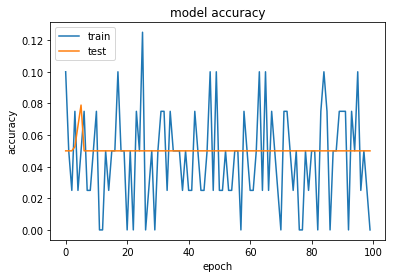

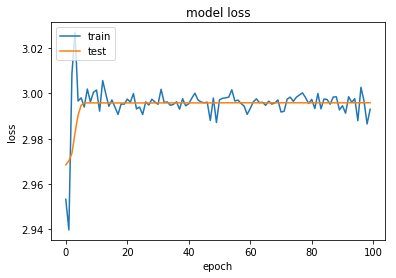

In [22]:
def plot_history(history, model_name='model'):
    """Takes a history object and makes some plots."""
    plt.plot(history.history['acc']);
    plt.plot(history.history['val_acc']);
    plt.title('{} accuracy'.format(model_name));
    plt.ylabel('accuracy');
    plt.xlabel('epoch');
    plt.legend(['train', 'test'], loc='upper left');
    plt.show();

    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.title('{} loss'.format(model_name));
    plt.ylabel('loss');
    plt.xlabel('epoch');
    plt.legend(['train', 'test'], loc='upper left');
    plt.show();
    return
    
plot_history(history)

In [25]:
results = quiz(model, test, labels)

Quiz results: 19 out of 380 correct.
Quiz accuracy score: 0.05. Error rate: 0.95
Classification results: 18 out of 380 correct.
Classification accuracy score: 0.047. Error rate: 0.953
